# ElasticNet model trained on epigenetic features and bulk RNA-seq
As the MTL models trained on the epigenetic data as features and single-cell StemNet RNa-seq data as response returned very poor results, we decided to train a single-task model on the same features but bulk RNA-seq used as response.

## Read the data

In [1]:
bulk <- read.csv("/MMCI/MS/ExpRegulation/work/data/singleCell/iPCs_Kathrin/bulkRNAseq_TPM_converted.csv")
feat <- read.csv("/MMCI/MS/ExpRegulation/work/data/singleCell/HepG2/G_MTL/monocle/scMTL_StemNet_imputed_epigenetic_feature_doubleReduced.txt")

In [2]:
rownames(bulk) <- bulk$X
bulk <- bulk[, -1]

rownames(feat) <- feat$X
feat <- feat[, -1]

print(dim(bulk))
print(dim(feat))

[1] 56757    11
[1] 9593  704


### Merged the features and responses to obtain the overlapping gene names

In [3]:
merged_data <- merge(bulk, feat, by= "row.names")

rownames(merged_data) <- merged_data$Row.names
merged_data <- merged_data[, -1]

### Separate the feature and responses from the merged data

In [4]:
y <- merged_data[, seq(ncol(bulk))]
x <- merged_data[, seq(ncol(bulk) + 1, ncol(merged_data))]

print(dim(y))
print(dim(x))

[1] 9593   11
[1] 9593  704


### Log-transform the data

In [5]:
x <- log2(1 + x)
y <- log2(1 + y)

### Choose only one of the available bulk RNA-seq

In [6]:
y <- y[, 1]

## Compute feature to response correlations

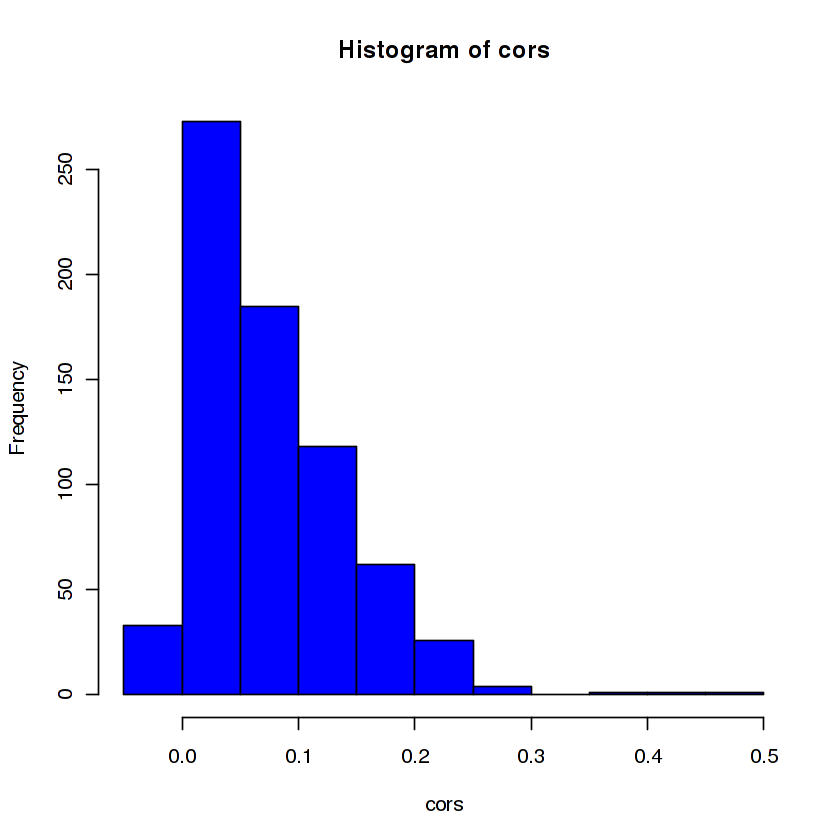

In [7]:
cors <- sapply(seq(ncol(x)), function(i)cor(y, x[, i]))
hist(cors, col= "blue")

# Train Elastic Net model

## Partition data into training and test sets
80% for training and 20% for test

In [8]:
train_cnt <- floor(nrow(x) * .8)
print(train_cnt)

[1] 7674


In [9]:
set.seed(1)
shuffle.idx <- sample(nrow(x))

In [10]:
train_x <- x[shuffle.idx[seq(train_cnt)], ]
train_y <- y[shuffle.idx[seq(train_cnt)]]

test_x <- x[-shuffle.idx[seq(train_cnt)], ]
test_y <- y[-shuffle.idx[seq(train_cnt)]]

print(dim(train_x))
print(dim(test_x))

[1] 7674  704
[1] 1919  704


In [11]:
mean.train <- apply(x, 2, FUN= mean)
sd.train <- apply(x, 2, FUN= sd)
train_x <- scale(train_x)

test_x <- scale(test_x, center = mean.train, scale = sd.train)

In [12]:
train_y <- scale(train_y)

col_means_train <- attr(train_y, "scaled:center") 
col_stddevs_train <- attr(train_y, "scaled:scale")
test_y <- scale(test_y, center = col_means_train, scale = col_stddevs_train)

In [13]:
library(glmnet)
library(doMC)
registerDoMC(cores= 20)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: iterators
Loading required package: parallel


## CV round on the denoted alpha search grid

In [14]:
alphas <- seq(0, 1, .05)
el.res <- list()
for(i in seq(length(alphas)))
    el.res[[i]] <- cv.glmnet(x= as.matrix(train_x), y= as.numeric(train_y), alpha= alphas[i], nfolds= 5, parallel= T, standardize =F)

## Fetch the best alpha value

In [15]:
all.cvms <- sapply(seq(length(el.res)), function(i) min(el.res[[i]]$cvm))
best.el.cv <- el.res[[which.min(all.cvms)]]
best_alpha_idx <- which.min(all.cvms)

## Train the final elastic net model with the selected optimal hyper-parameters obtained from the CV round

In [16]:
final_el <- glmnet(x= as.matrix(train_x), y= as.numeric(train_y), lambda= el.res[[best_alpha_idx]]$lambda.min,
                   alpha= alphas[best_alpha_idx])

### Best alpha

In [17]:
alphas[best_alpha_idx]

[1] 0.75

### Compute predictions on training data

In [18]:
pred.res.train <- predict(final_el, as.matrix(train_x),s= el.res[[best_alpha_idx]]$lambda.min, alpha= alphas[best_alpha_idx])
cor(pred.res.train, train_y)

0.514634


That's a good correlation! :)

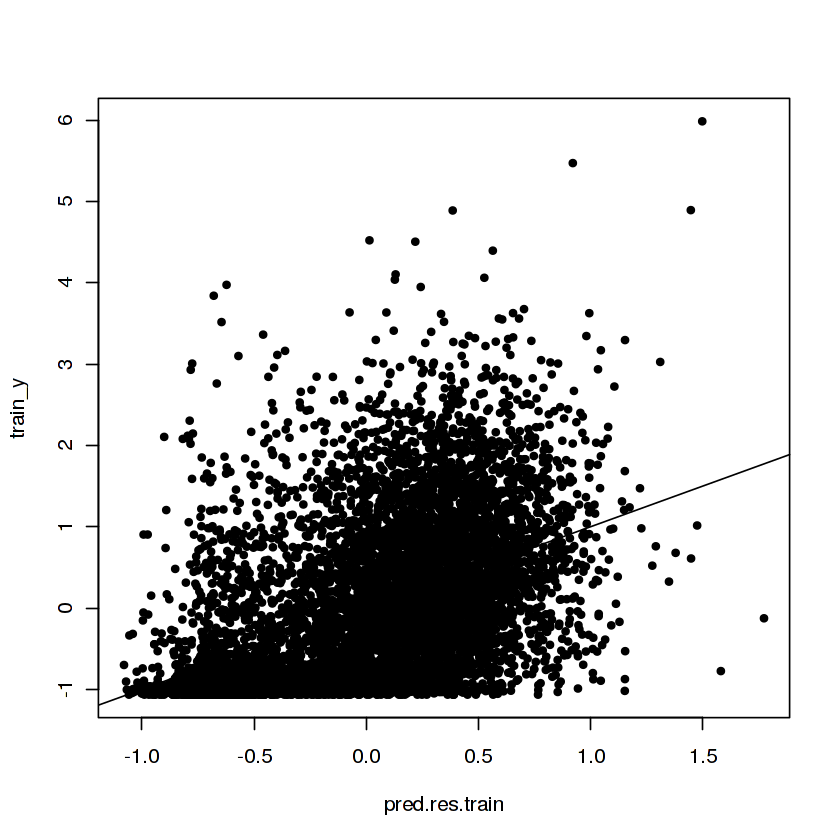

In [19]:
plot(pred.res.train, train_y, pch= 20)
abline(a= 0, b= 1)

### Compute predictions on test data

In [20]:
pred.res.test <- predict(final_el, as.matrix(test_x),s= el.res[[best_alpha_idx]]$lambda.min, alpha= alphas[best_alpha_idx])
cor.df <- data.frame(cor_val= cor(pred.res.test, test_y), cor_method= "Pearson")
cor.df <- rbind(cor.df, data.frame(cor_val= cor(pred.res.test, test_y, method= "spearman"), cor_method= "Spearman"))
cor.df

,cor_val,cor_method
1,0.5171655,Pearson
11,0.5713846,Spearman


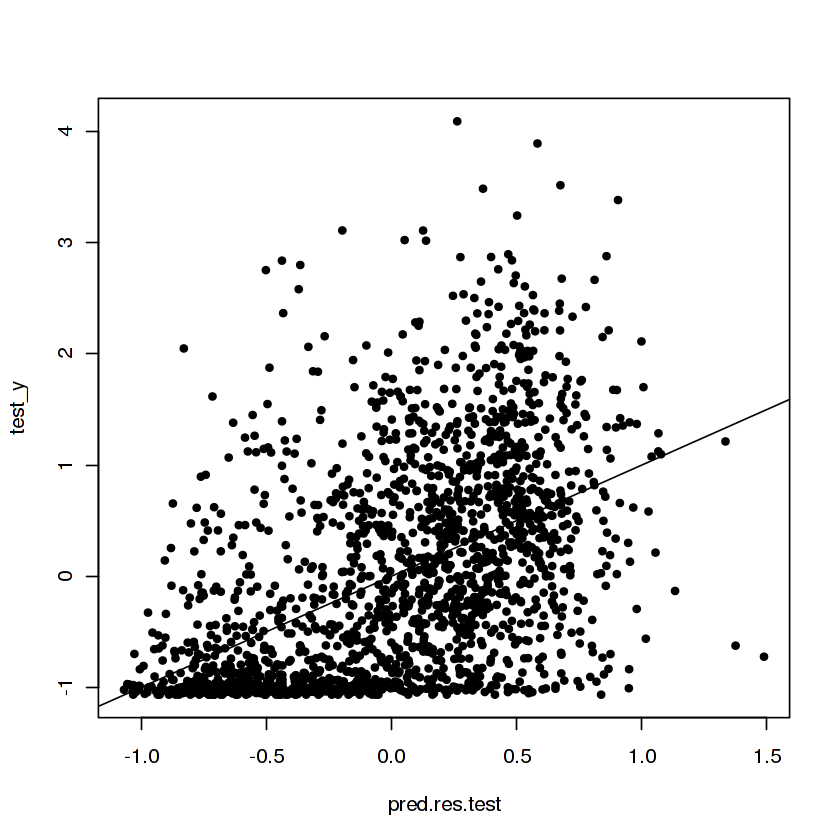

In [21]:
plot(pred.res.test, test_y, pch= 20)
abline(a= 0, b= 1)

## Model coefficients representing the top TFs

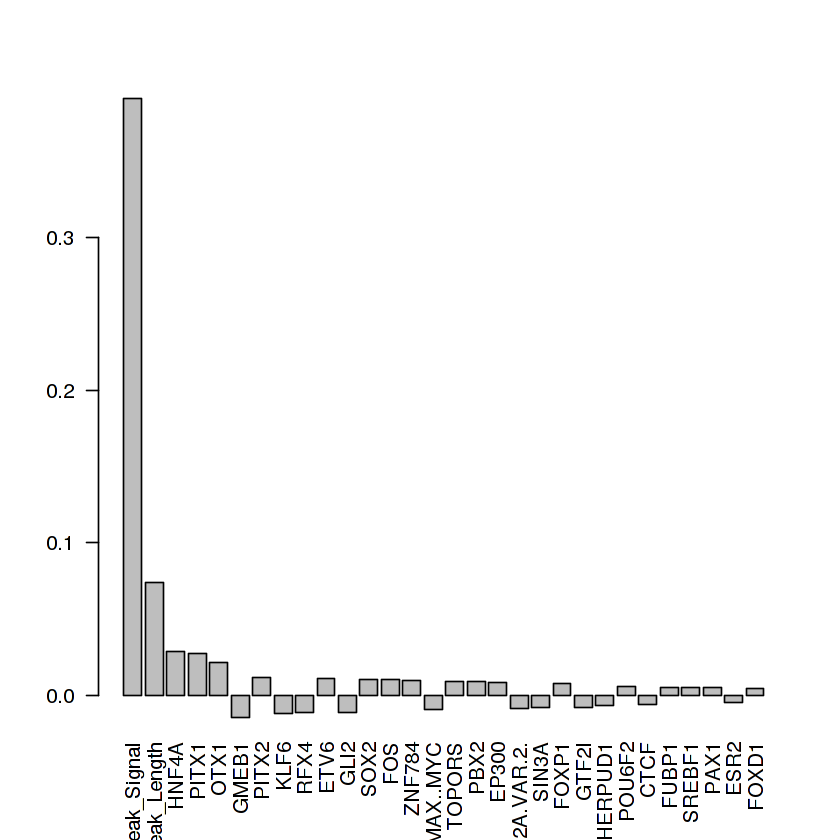

In [22]:
tf.names <- rownames(final_el$beta)
top.tfs <- order(abs(as.numeric(final_el$beta)), decreasing = T)[seq(30)]
barplot(as.numeric(final_el$beta)[top.tfs], las= 2, names.arg= tf.names[top.tfs])

## Examine the correlation between top TFs and response

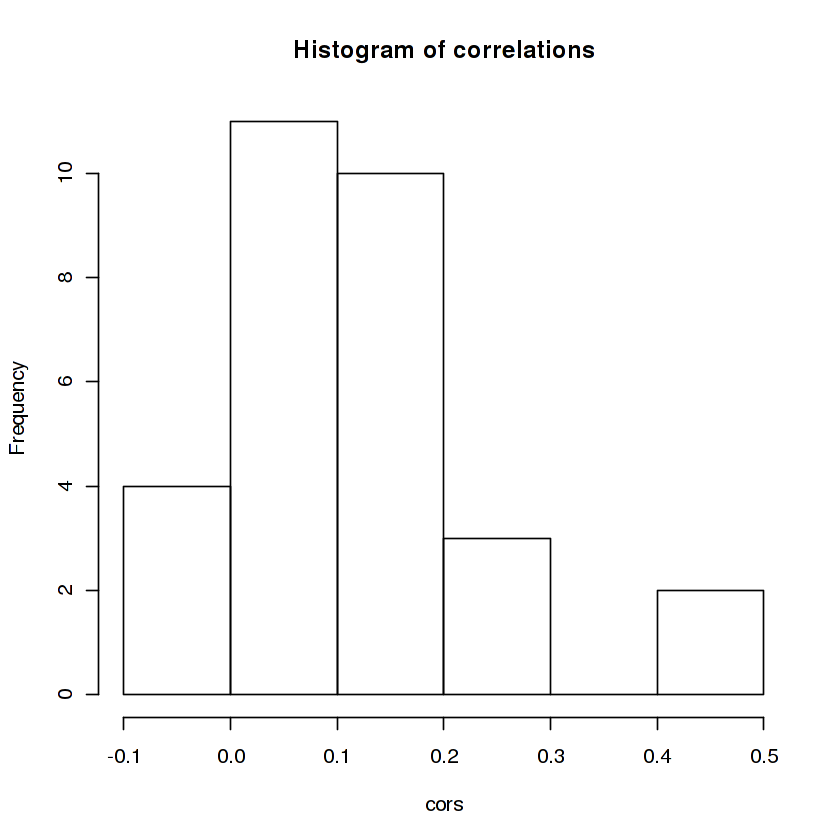

In [23]:
top_x <- train_x[, top.tfs]
cors <- sapply(seq(ncol(top_x)), function(i)cor(c(top_x[, i], test_x[, top.tfs[i]]), c(train_y, test_y)))
hist(cors, main= "Histogram of correlations")